In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.interpolate import griddata, interp1d

vel_folder = '/home/bmelo/bin/SeisBlast/1D_velocity/COOLE/'
tag = 'COOLE1'
input_file = vel_folder + 'v.in_' + tag

In [49]:
# Improved parser that considers continuation of geometry or velocity blocks based on layer and flag indicators
def parse_velocity_model(filepath):
    layers = []
    with open(filepath, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]

    i = 0
    current_layer = None
    block_stage = 0  # 0 = (x, z), 1 = (x, vp_min), 2 = (x, vp_max)
    layer_data = {}
    buffer_x = []
    buffer_y = []

    while i < len(lines) - 2:
        # Read line 1: layer ID + x values
        line1 = lines[i].split()
        layer_id = int(line1[0])
        x_vals = list(map(float, line1[1:]))

        # Read line 2: flag + y values (z or v)
        line2 = lines[i + 1].split()
        flag = int(line2[0])
        y_vals = list(map(float, line2[1:]))

        # Skip dummy line
        i += 3

        # If new layer: flush and reset
        if current_layer != layer_id:
            if layer_data:
                layers.append(layer_data)
            current_layer = layer_id
            layer_data = {"n": current_layer - 1, "x": [], "z": [], "x_vel": [], "vp_min": [], "vp_max": []}
            block_stage = 0
            buffer_x = []
            buffer_y = []

        # If continuation line (flag=1), accumulate
        if flag == 1:
            buffer_x.extend(x_vals)
            buffer_y.extend(y_vals)
            continue

        # If new block starts (flag=0), flush previous if needed
        if buffer_x and buffer_y:
            x_vals = buffer_x + x_vals
            y_vals = buffer_y + y_vals
            buffer_x = []
            buffer_y = []

        # Assign to appropriate fields
        if block_stage == 0:  # (x, z)
            layer_data["x"] = x_vals
            layer_data["z"] = y_vals
        elif block_stage == 1:  # (x_vel, vp_min)
            layer_data["x_vel"] = x_vals
            layer_data["vp_min"] = y_vals
        elif block_stage == 2:  # (x_vel, vp_max)
            layer_data["vp_max"] = y_vals

        # Advance block stage
        block_stage = (block_stage + 1) % 3

    # Add last layer
    if layer_data:
        layers.append(layer_data)

    return layers

# Apply parser to uploaded file
layers = parse_velocity_model(input_file)

# --- SAVE LAYER BOUNDARIES TO CSV ---
boundary_rows = []
for layer in layers:
    for xi, zi in zip(layer["x"], layer["z"]):
        boundary_rows.append({"layer": layer["n"], "x": xi, "z": zi})

df_bounds = pd.DataFrame(boundary_rows)
df_bounds.to_csv(vel_folder+tag+"_layers.csv", index=False)
print("Layer boundaries saved to .csv")


Layer boundaries saved to .csv


In [50]:
#interpolate, save and plot velocity model 
# --- CONFIGURATION ---
dx = 1.0  # horizontal resolution (km)
dz = 0.1  # vertical resolution (km)

# Find full horizontal extent
x_min = min([min(layer["x"]) for layer in layers])
x_max = max([max(layer["x"]) for layer in layers])
x_grid = np.arange(x_min, x_max + dx, dx)

# Estimate maximum depth for Z grid
#z_max = max([max(layer["z"]) for layer in layers])
z_max = 35.0
z_grid = np.arange(0, z_max + dz, dz)

# Prepare 2D Vp grid
X, Z = np.meshgrid(x_grid, z_grid)
Vp_grid = np.full_like(X, np.nan, dtype=float)

# --- INTERPOLATION LOOP ---
for i, layer in enumerate(layers):
    x_top = np.array(layer["x"])
    z_top = np.array(layer["z"])

    # Interpolate z_top onto the global x_grid
    f_z_top = interp1d(x_top, z_top, bounds_error=False, fill_value="extrapolate")
    z_top_interp = f_z_top(x_grid)

    # Infer z_bottom from z_top of the next layer
    if i < len(layers) - 1:
        x_next = np.array(layers[i + 1]["x"])
        z_next = np.array(layers[i + 1]["z"])
        f_z_bottom = interp1d(x_next, z_next, bounds_error=False, fill_value="extrapolate")
        z_bottom_interp = f_z_bottom(x_grid)
    else:
        # For the last layer, extend downward a bit
        z_bottom_interp = z_top_interp + 5.0

    # Interpolate vp_min over x
    vp_avg = np.mean([layer["vp_min"], layer["vp_max"]], axis=0)
    f_vp = interp1d(layer["x_vel"], vp_avg, bounds_error=False, fill_value="extrapolate")
    vp_x_interp = f_vp(x_grid)
    
    # Fill Vp_grid values within the layer depth interval
    for xi, x in enumerate(x_grid):
        zmin = z_top_interp[xi]
        zmax = z_bottom_interp[xi]

        # Boolean mask for vertical values between top and bottom at this x
        z_mask = (Z[:, xi] >= zmin) & (Z[:, xi] < zmax)

        # Assign interpolated Vp to all valid Z positions at column xi
        Vp_grid[z_mask, xi] = vp_x_interp[xi]
        
# --- SAVE INTERPOLATED GRID TO NETCDF ---
ds = xr.Dataset(
    data_vars={
        "vp": (("z", "x"), Vp_grid)
    },
    coords={
        "x": x_grid,
        "z": z_grid
    },
    attrs={
        "title": "Interpolated 2D Vp model",
        "description": "generated from " + tag,
        "units": "Vp in km/s, depth in km, distance in km"
    }
)
ds.to_netcdf(vel_folder+tag+"_vp.nc")
print("Interpolated Vp grid saved to .nc")

Interpolated Vp grid saved to .nc


/home/bmelo/miniconda3/envs/seisblast/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


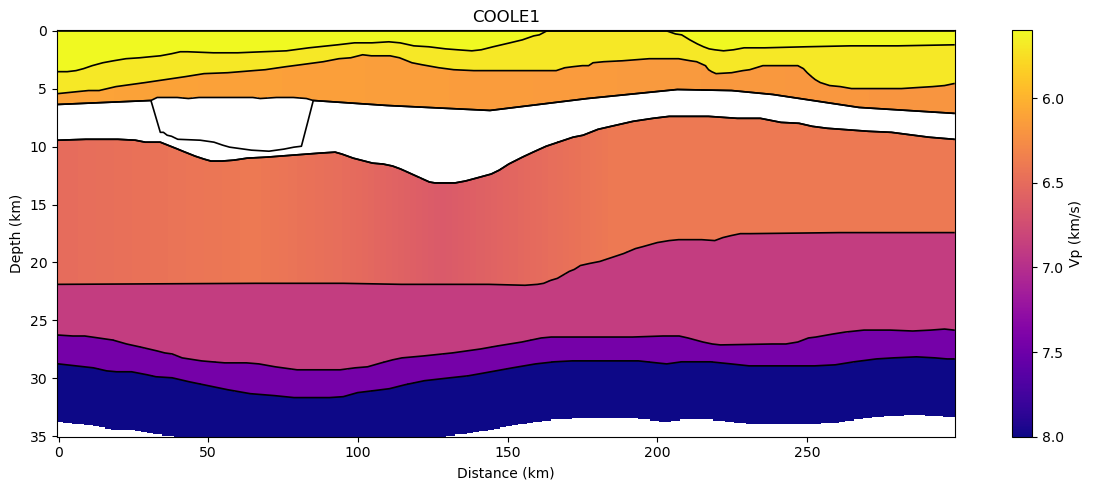

In [51]:
# --- PLOTTING ---
fig, ax = plt.subplots(figsize=(12, 5))
c = plt.pcolormesh(X, Z, Vp_grid, shading='auto', cmap='plasma_r')
# Overlay each layer top boundary
for i, layer in enumerate(layers):
    x_top = np.array(layer["x"])
    z_top = np.array(layer["z"])
    ax.plot(x_top, z_top, color='k', linewidth=1.2)

plt.gca().invert_yaxis()  # Ensure depth is increasing downward
plt.xlabel("Distance (km)")
plt.ylabel("Depth (km)")
cbar = plt.colorbar(c, label="Vp (km/s)")
cbar.ax.invert_yaxis()
plt.title(tag)
plt.tight_layout()
plt.show()

#save figure
fig.savefig(vel_folder+tag+"_vp.png", dpi=300)

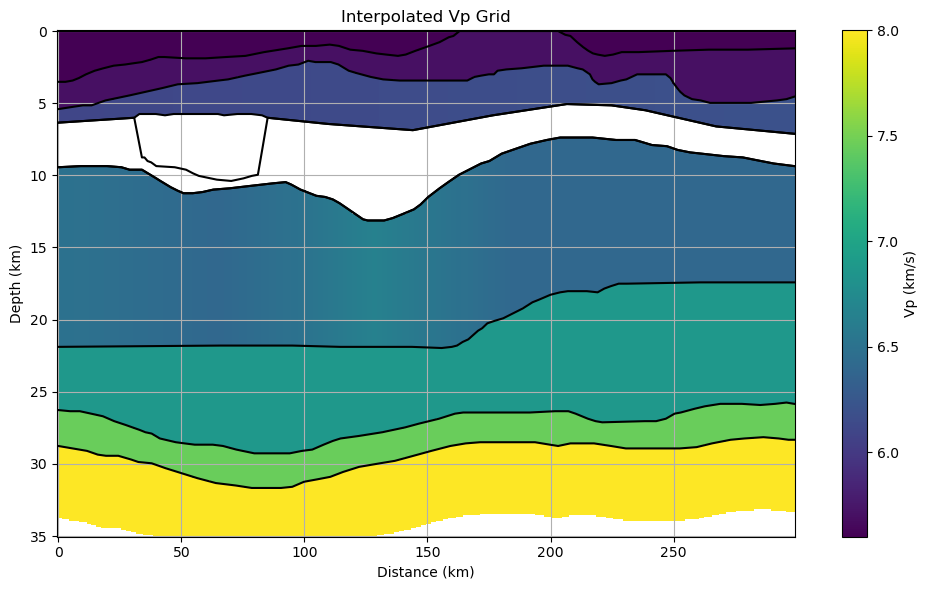

In [52]:
#or plot directly from the saved files
# Load the dataset
ds = xr.open_dataset(vel_folder+tag+"_vp.nc")
df = pd.read_csv(vel_folder+tag+"_layers.csv")

# Access coordinates and velocity
x = ds["x"]
z = ds["z"]
vp = ds["vp"]

# Plot
plt.figure(figsize=(10, 6))
plt.pcolormesh(x, z, vp, shading="auto", cmap="viridis")
for layer_id, group in df.groupby("layer"):
    plt.plot(group["x"], group["z"], color="black", linewidth=1.5)

plt.gca().invert_yaxis()  # depth increases downward

plt.colorbar(label="Vp (km/s)")
plt.xlabel("Distance (km)")
plt.ylabel("Depth (km)")
plt.title("Interpolated Vp Grid")
plt.grid(True)
plt.tight_layout()
plt.show()

In [53]:
# #save as netcdf for grid handling in the future
# import xarray as xr

# def layers_to_netcdf(layers, filename="velocity_profiles.nc"):
#     max_len = max(len(l["x_vel"]) for l in layers)
#     n_layers = len(layers)

#     vp = np.full((n_layers, max_len), np.nan)
#     x = np.full((n_layers, max_len), np.nan)
#     z = np.full((n_layers, max_len), np.nan)

#     for i, layer in enumerate(layers):
#         n = len(layer["x_vel"])
#         vp[i, :n] = layer["vp_min"]
#         x[i, :n] = layer["x_vel"]

#         # Interpolate Z from geometry to velocity x-coordinates
#         if layer["x"] and layer["z"]:
#             z_interp = np.interp(layer["x_vel"], layer["x"], layer["z"])
#             z[i, :n] = z_interp

#     ds = xr.Dataset(
#         data_vars={
#             "vp_min": (("layer", "x_index"), vp),
#             "x": (("layer", "x_index"), x),
#             "z": (("layer", "x_index"), z),
#         },
#         coords={
#             "layer": np.arange(n_layers),
#             "x_index": np.arange(max_len),
#         }
#     )

#     ds.to_netcdf(vel_folder+filename)
#     print(f"NetCDF saved to {filename}")

In [54]:
# # VARNET LINE A DATA
# layers = [
#     {#1
#         "n": 0,
#         "x": [0.00, 18.00, 75.00, 85.00, 100.00, 130.00, 150.00, 180.00, 200.10],
#         "z": [0.0] * 9,
#         "x_vel": [0.00, 18.00, 75.00, 85.00, 100.00, 130.00, 150.00, 180.00, 200.10],
#         "vp_min": [4.50, 5.20, 4.90, 5.40, 5.40, 5.40, 5.90, 5.95, 5.95],
#         "vp_max": [4.60, 5.30, 5.00, 5.60, 5.60, 5.60, 6.00, 6.00, 6.00],
#     },
#     {#2
#         "n": 1,
#         "x": [0.00, 15.00, 50.00, 78.00, 100.00, 134.00, 140.00, 150.00, 170.00, 200.10],
#         "z": [3.00, 3.00, 0.50, 0.50, 2.00, 3.00, 0.50, 0.50, 1.80, 2.00],
#         "x_vel": [0.00, 20.00, 35.00, 60.00, 75.00, 85.00, 130.00, 140.00, 150.00, 170.10],
#         "vp_min": [5.00, 5.40, 5.50, 5.70, 5.70, 5.60, 5.70, 6.05, 6.05, 6.00],
#         "vp_max": [5.20, 5.60, 5.80, 5.85, 5.80, 5.80, 5.80, 6.10, 6.10, 6.00],
#     },
#     {#3
#         "n": 2,
#         "x": [0.00, 80.00, 135.00, 200.10],
#         "z": [6.00, 5.50, 5.50, 6.00],
#         "x_vel": [0.00, 70.00, 80.00, 130.00, 140.00, 200.10],
#         "vp_min": [5.90, 5.90, 5.85, 5.85, 6.10, 6.10],
#         "vp_max": [6.00, 6.00, 6.00, 5.90, 6.10, 6.10],
#     },
#     {#4
#         "n": 3,
#         "x": [0.00, 60.00, 130.00, 200.10],
#         "z": [12.00, 11.00, 11.00, 12.00],
#         "x_vel": [0.00, 60.00, 80.00, 130.00, 140.00, 200.10],
#         "vp_min": [6.05, 6.05, 6.05, 6.10, 6.30, 6.30],
#         "vp_max": [6.10, 6.10, 6.05, 6.10, 6.30, 6.30],
#     },
#     {#5
#         "n": 4,
#         "x": [0.00, 110.00, 140.00, 200.10],
#         "z": [16.00, 15.00, 16.00, 16.00],
#         "x_vel": [0.00, 100.00, 140.00, 200.10],
#         "vp_min": [6.40, 6.40, 6.55, 6.55],
#         "vp_max": [6.50, 6.50, 6.55, 6.55],
#     },
#     {#6
#         "n": 5,
#         "x": [0.00, 49.04, 68.46, 121.11, 143.49, 153.37, 200.10],
#         "z": [21.06, 21.79, 21.98, 22.53, 23.05, 23.05, 23.49],
#         "x_vel": [0.00, 80.00, 110.00, 200.10],
#         "vp_min": [6.80, 6.80, 6.85, 6.90],
#         "vp_max": [6.80, 6.80, 6.85, 6.90],
#     },
#     {#7
#         "n": 6,
#         "x": [0.00, 50.68, 69.11, 87.87, 135.26, 200.10],
#         "z": [25.49, 25.93, 26.26, 26.82, 26.60, 27.93],
#         "x_vel": [0.00,100.00,200.10],
#         "vp_min": [7.00, 7.20, 7.20],
#         "vp_max": [7.00, 7.20, 7.20],
#     },
#     {#8
#         "n": 7,
#         "x": [0.00, 100.00, 119.14, 136.25, 149.09, 164.88, 200.10],
#         "z": [31.00, 32.00, 30.81, 30.64, 31.58, 32.52, 33.19],
#         "x_vel": [0.00,100.00,200.10],
#         "vp_min": [8.20, 8.20, 8.20],
#         "vp_max": [8.20, 8.20, 8.20],
#     },
# ]

# #np.mean(layers[1]["z"])